<a href="https://colab.research.google.com/github/LapTQ/surface_defect_detection/blob/main/surface_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets:
* Detection
 * [Steel Surface: NEU-CLS](http://faculty.neu.edu.cn/songkc/en/zdylm/263265/list/index.htm)
 * [DeepPBC](https://github.com/Charmve/Surface-Defect-Detection/tree/master/DeepPCB)
* Segmenation
 * [Severstal: Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection/overview)
 * [AITEX FABRIC IMAGE DATABASE](https://www.aitex.es/afid/)

* EDA
* algorithms to detect ROI then classify (2 stages): faster RCNN, seam carving, interest points,...
* classify then detect ROI: saliency map
* compare to papers with the same dataset

https://towardsdatascience.com/i-performed-error-analysis-on-open-images-and-now-i-have-trust-issues-89080e03ba09

https://stackoverflow.com/questions/67244258/how-to-get-class-and-bounding-box-coordinates-from-yolov5-predictions

https://docs.ultralytics.com/tutorials/pytorch-hub/

https://stackoverflow.com/questions/54165439/what-are-the-exact-color-names-available-in-pils-imagedraw

## Import

In [1]:
!git clone https://github.com/LapTQ/surface_defect_detection.git
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

Cloning into 'surface_defect_detection'...
remote: Enumerating objects: 3845, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 3845 (delta 14), reused 0 (delta 0), pack-reused 3821
Receiving objects: 100% (3845/3845), 818.32 MiB | 44.98 MiB/s, done.
Resolving deltas: 100% (1837/1837), done.
Checking out files: 100% (3610/3610), done.
Cloning into 'yolov5'...
remote: Enumerating objects: 11413, done.
remote: Total 11413 (delta 0), reused 0 (delta 0), pack-reused 11413
Receiving objects: 100% (11413/11413), 11.29 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (7876/7876), done.
     |████████████████████████████████| 596 kB 23.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
import numpy as np
import tensorflow as tf
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.10.0+cu111 CPU


## EDA

In [3]:
print('[INFO] number of xml files:', len(list(Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'))))
print('[INFO] number of images (.jpg) files:', len(list(Path('surface_defect_detection/NEU-DET/IMAGES').glob('*.jpg'))))

[INFO] number of xml files: 1800
[INFO] number of images (.jpg) files: 1800


In [4]:
# show an example
!cat surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml

<annotation>
	<folder>cr</folder>
	<filename>crazing_2.jpg</filename>
	<source>
		<database>NEU-DET</database>
	</source>
	<size>
		<width>200</width>
		<height>200</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>99</xmin>
			<ymin>120</ymin>
			<xmax>200</xmax>
			<ymax>174</ymax>
		</bndbox>
	</object>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>16</ymin>
			<xmax>200</xmax>
			<ymax>111</ymax>
		</bndbox>
	</object>
</annotation>


In [5]:
def extract_info_from_xml(xml_file):
    """Read xml file and extract information.
    Arguments:
        xml_file - path to the xml file.
    Return a dictionary containing info.
    """
    xml_root = ET.parse(xml_file).getroot()

    info = {}
    info['bboxes'] = []
    
    for element in xml_root:
        # get image file name
        if element.tag == 'filename':
            info['filename'] = element.text

        # get image size
        if element.tag == 'size':
            image_size = []
            for sub_element in element:
                info['image_' + sub_element.tag] = int(sub_element.text)
        
        # get bounding boxes
        if element.tag == 'object':
            bbox = {}
            for sub_element in element:
                if sub_element.tag == 'name':
                    bbox['class'] = sub_element.text
                elif sub_element.tag == 'bndbox':
                    for sub_sub_element in sub_element:
                        bbox[sub_sub_element.tag] = int(sub_sub_element.text)
            info['bboxes'].append(bbox)
    return info

In [6]:
extract_info_from_xml('surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml')

{'bboxes': [{'class': 'crazing',
   'xmax': 200,
   'xmin': 99,
   'ymax': 174,
   'ymin': 120},
  {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}],
 'filename': 'crazing_2.jpg',
 'image_depth': 1,
 'image_height': 200,
 'image_width': 200}

In [7]:
class_name_to_id_mapping = {
    'crazing': 0, 
    'inclusion': 1, 
    'patches': 2, 
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5
}
class_id_to_name_mapping = {class_id: class_name for class_name, class_id in class_name_to_id_mapping.items()}
class_id_to_name_mapping

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}

In [8]:
!mkdir dataset
!mkdir dataset/labels
!cp -r surface_defect_detection/NEU-DET/IMAGES /content/dataset/images

In [9]:
def convert_to_yolov5(info):
    """Convert extracted info into yolov5 required format and save it in a new labels directory.
    Argument:
        info - Python dictionary. Eg:
            {
            'bboxes': [
                        {'class': 'crazing', 'xmax': 200, 'xmin': 99, 'ymax': 174, 'ymin': 120},
                        {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}
                      ],
            'filename': 'crazing_2.jpg',
            'image_size': (200, 200, 1)
            }
    => converted as: class_id x y w h
        0 0.747500 0.735000 0.505000 0.270000
        0 0.520000 0.317500 0.960000 0.475000

    """
    buffer = []

    for bbox in info['bboxes']:
        try:
            class_id = class_name_to_id_mapping[bbox['class']]
        except KeyError:
            print('Invalid class. Must be one from', class_name_to_id_mapping)

        # convert to [x, y, w, h]
        bx = (bbox['xmin'] + bbox['xmax']) / 2
        by = (bbox['ymin'] + bbox['ymax']) / 2
        bw = (bbox['xmax'] - bbox['xmin'])
        bh = (bbox['ymax'] - bbox['ymin'])

        # normalize bbox dimensions
        bx /= info['image_width']
        by /= info['image_height']
        bw /= info['image_width']
        bh /= info['image_height']

        buffer.append('{} {:3f} {:3f} {:3f} {:3f}'.format(class_id, bx, by, bw, bh))
    
    # store in .txt file
    save_filename = os.path.join('dataset/labels', info['filename'].replace('.jpg', '') + '.txt')
    print('\n'.join(buffer), file=open(save_filename, 'w'))
    return {'class_id': class_id,
            'bx': bx,
            'by': by,
            'bw': bw,
            'bh': bh}

In [10]:
# Extract info from .xml files and save in .txt files
for ann in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
    info = extract_info_from_xml(ann)
    convert_to_yolov5(info)

In [11]:
# check for any missing
assert len(list(Path('dataset/labels').glob('*.txt'))) == len(list(Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'))), "Missing some .txt files"
assert len(list(Path('dataset/images').glob('*.jpg'))) == len(list(Path('surface_defect_detection/NEU-DET/IMAGES').glob('*.jpg'))), "Missing some images"

In [12]:
# # extract info from annotation folder and store in a Dataframe
# info_list = []
# for xml_path in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
#     info = extract_info_from_xml(xml_path)
#     for bbox in info['bboxes']:
#         info_list.append(
#             {'image_width': info['image_width'],
#              'image_height': info['image_height'],
#              'image_depth': info['image_depth'],
#              'filename': info['filename'],
#              'class': bbox['class'],
#              'xmin': bbox['xmin'],
#              'ymin': bbox['ymin'],
#              'xmax': bbox['xmax'],
#              'ymax': bbox['ymax'],
#             #  'bbox_x': (bbox['xmin'] + bbox['xmax']) / 2,
#             #  'bbox_y': (bbox['ymin'] + bbox['ymax']) / 2,
#             #  'bbox_width': (bbox['xmax'] - bbox['xmin']),
#             #  'bbox_height': (bbox['ymax'] - bbox['ymin'])
#              }
#         )

# info_df = pd.DataFrame.from_dict(info_list)
# info_df

In [13]:
# print("[INFO] number of images:", len(info_df['filename'].unique()))
# print("[INFO] image size: ({}, {}, {})".format(info_df['image_width'].unique()[0], info_df['image_height'].unique()[0], info_df['image_depth'].unique()[0]))
# info_df.groupby('class')['class'].count().plot.bar(ylabel='number of object', rot=15)

# # info_df['x'] = (info_df['xmin'] + info_df['xmax']) / 2
# # info_df['y'] = (info_df['ymin'] + info_df['ymax']) / 2
# info_df['w'] = (info_df['xmax'] - info_df['xmin'])
# info_df['h'] = (info_df['ymax'] - info_df['ymin'])

# colors = {
#     'crazing': (0, 0, 1),
#     'inclusion': (0, 1, 0),
#     'patches': (1, 0, 0),
#     'pitted_surface': (1, 1, 0),
#     'rolled-in_scale': (1, 0, 1),
#     'scratches': (0, 1, 1)
# }
# plt.figure(figsize=(15, 15))
# ax = plt.gca()
# for index in info_df.index:
#     patch = plt.Rectangle([100 - info_df.iloc[index]['w']/2, 100 - info_df.iloc[index]['h']/2], info_df.iloc[index]['w'], info_df.iloc[index]['h'],
#                           fill=False, edgecolor=colors[info_df.iloc[index]['class']], linewidth=1)
#     ax.add_patch(patch)
# plt.ylim([0, 200])
# plt.xlim([0, 200])
# plt.show()


In [14]:
tf.keras.utils.get_file(origin='https://ultralytics.com/assets/Arial.ttf')

def plot_bbox(image, annotations):
    """
    Arguments:
        image - array in range [0, 255]
        annotations - numpy array,
            if shape is (n, 6): each bbox is of format (bx, by, bw, bh, conf, class_id)
            if shape is (n, 5): each bbox is of format (bx, by, bw, bh, class_id)
    """
    image = Image.fromarray(image)  # convert to PIL Image
    # annotations = np.array(annotations)
    image_w, image_h = image.size

    plotted_img = ImageDraw.Draw(image)

    # convert [bx, by, bw, bh] to actual size in pixel [x, y, w, h]
    transformed_ann = np.copy(annotations)
    transformed_ann[:, [0, 2]] = annotations[:, [0, 2]] * image_w
    transformed_ann[:, [1, 3]] = annotations[:, [1, 3]] * image_h
    
    # convert [x, y, w, h] to [xmin, ymin, xmax, ymax]
    transformed_ann[:, 0] -= transformed_ann[:, 2] / 2
    transformed_ann[:, 1] -= transformed_ann[:, 3] / 2
    transformed_ann[:, 2] += transformed_ann[:, 0]
    transformed_ann[:, 3] += transformed_ann[:, 1]

    class_name_to_color_mapping = {
        'crazing': 'red',
        'inclusion': 'orange',
        'patches': 'darkgoldenrod',
        'pitted_surface': 'deepskyblue',
        'rolled-in_scale': 'mediumseagreen',
        'scratches': 'deeppink'
    }
    font = ImageFont.truetype('/root/.keras/datasets/Arial.ttf', 12)

    for ann in transformed_ann:
        (xmin, ymin, xmax, ymax), class_name = ann[:4], class_id_to_name_mapping[int(ann[-1])]
        xmin = max(xmin, 0)
        ymin = max(ymin, 0)
        xmax = min(xmax, image_w)
        ymax = min(ymax, image_h)
        color = class_name_to_color_mapping[class_name]
        plotted_img.rectangle(((xmin, ymin), (xmax, ymax)), outline=color)
        
        msg = ' ' + class_name + (': {:.2f} '.format(ann[-2]) if transformed_ann.shape[-1] == 6 else ' ')
        text_w, text_h = font.getsize(msg)
        plotted_img.rectangle(((xmin, ymin), (xmin + text_w, ymin + text_h)), fill=color, outline=color)
        plotted_img.text((xmin, ymin), msg, fill='white', font=font)
    
        
    
    plt.imshow(image)
    plt.show()

786432/773236 [==============================] - 0s 0us/step


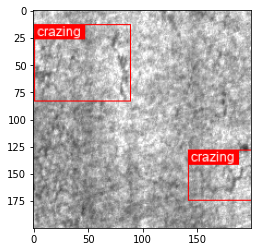

In [15]:
# show an example
annotation_file = random.choice(list(Path('dataset/labels').glob('*.txt')))
with open(annotation_file, 'r') as f:
    annotations = f.read().split('\n')[:-1]
    annotations = [_.split() for _ in annotations]
    annotations = np.array([[float(__) for __ in _] for _ in annotations])

image = plt.imread(str(annotation_file).replace('labels', 'images').replace('txt', 'jpg'))
plot_bbox(image, annotations[:, [1, 2, 3, 4, 0]]) # convert [class_id, bx, by, bw, bh] to [bx, by, bw, bh, class_id]

## Preparing dataset for YOLOv5

In [16]:
annotations = sorted([str(_) for _ in Path('dataset/labels').glob('*.txt')])
images = [_.replace('labels', 'images').replace('txt', 'jpg') for _ in annotations]

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=42)

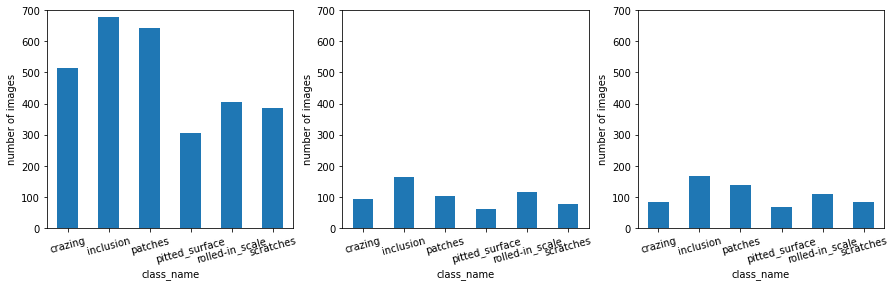

In [17]:
def annotations_to_df(file_list):
    buffer = []
    for txt in file_list:
        with open(txt, 'r') as f:
            annotation_list = f.read().split('\n')[:-1]
            annotation_list = [_.split() for _ in annotation_list]
            for bbox in annotation_list:
                buffer.append(
                    {
                    'filename': txt.split('/')[-1],
                    'class_name': class_id_to_name_mapping[int(bbox[0])],
                    'bx': float(bbox[1]),
                    'by': float(bbox[2]),
                    'bw': float(bbox[3]),
                    'bh': float(bbox[4])
                    }
                )
    return pd.DataFrame.from_dict(buffer)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
annotations_to_df(train_annotations).groupby('class_name')['class_name'].count().plot.bar(ylabel='number of images', rot=15)
plt.ylim([0, 700])
plt.subplot(1, 3, 2)
annotations_to_df(val_annotations).groupby('class_name')['class_name'].count().plot.bar(ylabel='number of images', rot=15)
plt.ylim([0, 700])
plt.subplot(1, 3, 3)
annotations_to_df(test_annotations).groupby('class_name')['class_name'].count().plot.bar(ylabel='number of images', rot=15)
plt.ylim([0, 700])
plt.show()

In [18]:
!mkdir dataset/images/train dataset/images/val dataset/images/test dataset/labels/train dataset/labels/val dataset/labels/test

In [19]:
def move_files_to_folder(file_list, destination_folder):
    for f in file_list:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

move_files_to_folder(train_images, 'dataset/images/train')
move_files_to_folder(val_images, 'dataset/images/val')
move_files_to_folder(test_images, 'dataset/images/test')
move_files_to_folder(train_annotations, 'dataset/labels/train')
move_files_to_folder(val_annotations, 'dataset/labels/val')
move_files_to_folder(test_annotations, 'dataset/labels/test')

In [20]:
with open('yolov5/data/surface_defect_data.yaml', 'w') as f:
    f.write(f"""train: ../dataset/images/train/
val: ../dataset/images/val/
test: ../dataset/images/test/

# number of classes
nc: 6

# class names
names: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']""")

## Training Yolov5

In [ ]:
# train yolov5x model
%cd yolov5
!python train.py --img 640 --batch 16 --epochs 50 --data surface_defect_data.yaml --weights yolov5x.pt --workers 24 --name yolo_surface_defect --cache
# continue training: --weights runs/train/yolo_surface_defect/weights/best.pt
# %cd ..

In [ ]:
# archive weights
!tar -czf ../yolov5_train.tar.gz runs/train/yolo_surface_defect
!tar -czf - runs/train/yolo_surface_defect | split --bytes=99MB - ../yolov5_train.tar.gz

In [ ]:
# get prediction on test images
!python detect.py --source ../dataset/images/test/ --weights runs/train/yolo_surface_defect2/weights/best.pt --conf 0.25 --name yolo_surface_defect

In [ ]:
detection_dir = 'runs/detect/yolo_surface_defect'

random_test_image = Image.open(random.choice(list(Path(detection_dir).glob('*'))))
plt.imshow(random_test_image)

In [ ]:
# evaluate on test images
!python val.py --weights runs/train/yolo_surface_defect/weights/best.pt --data surface_defect_data.yaml --task test --name yolo_surface_defect

In [ ]:
!tar -czf ../yolov5_val.tar.gz runs/val/yolo_surface_defect
!tar -czf ../yolov5_test.tar.gz runs/val/yolo_surface_defect2

## Load Pytorch hub model

In [20]:
!mkdir saved_model
!mkdir saved_model/yolov5

In [21]:
!cat surface_defect_detection/saved_model/yolov5_train.tar.gza* > surface_defect_detection/saved_model/yolov5_train.tar.gz
!tar -xf surface_defect_detection/saved_model/yolov5_train.tar.gz -C saved_model/yolov5

In [ ]:
!tar -xf surface_defect_detection/saved_model/yolov5_test.tar.gz -C saved_model/yolov5
!tar -xf surface_defect_detection/saved_model/yolov5_val.tar.gz -C saved_model/yolov5

In [23]:
yolov5_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/saved_model/yolov5/runs/train/yolo_surface_defect/weights/best.pt')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-3-18 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 444 layers, 86207059 parameters, 0 gradients, 204.1 GFLOPs
Adding AutoShape... 


In [24]:
!python yolov5/val.py --weights saved_model/yolov5/runs/train/yolo_surface_defect/weights/best.pt --data surface_defect_data.yaml --task test --name yolo_surface_defect

val: data=/content/yolov5/data/surface_defect_data.yaml, weights=['saved_model/yolov5/runs/train/yolo_surface_defect/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_surface_defect, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-38-g7c6a335 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 444 layers, 86207059 parameters, 0 gradients, 204.1 GFLOPs
test: Scanning '/content/yolov5/../dataset/labels/test' images and labels...270 found, 0 missing, 0 empty, 0 corrupt: 100% 270/270 [00:00<00:00, 1733.10it/s]
test: New cache created: /content/yolov5/../dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0% 0/9 [00:00<?, ?it/s]tcmalloc: large alloc 1156055040 bytes == 0x55c26764a000 @  0x7f02523beb6b 0x7f02523d

In [25]:
crazing_annotations = list(Path('dataset/labels/test').glob('crazing*.txt'))
crazing_images = [str(_).replace('labels', 'images').replace('txt', 'jpg') for _ in crazing_annotations]
results = yolov5_model(crazing_images, size=200)

In [26]:
results.pandas().xywh[0]

,xcenter,ycenter,width,height,confidence,class,name
0,101.297676,54.873119,197.110123,102.285378,0.75567,0,crazing


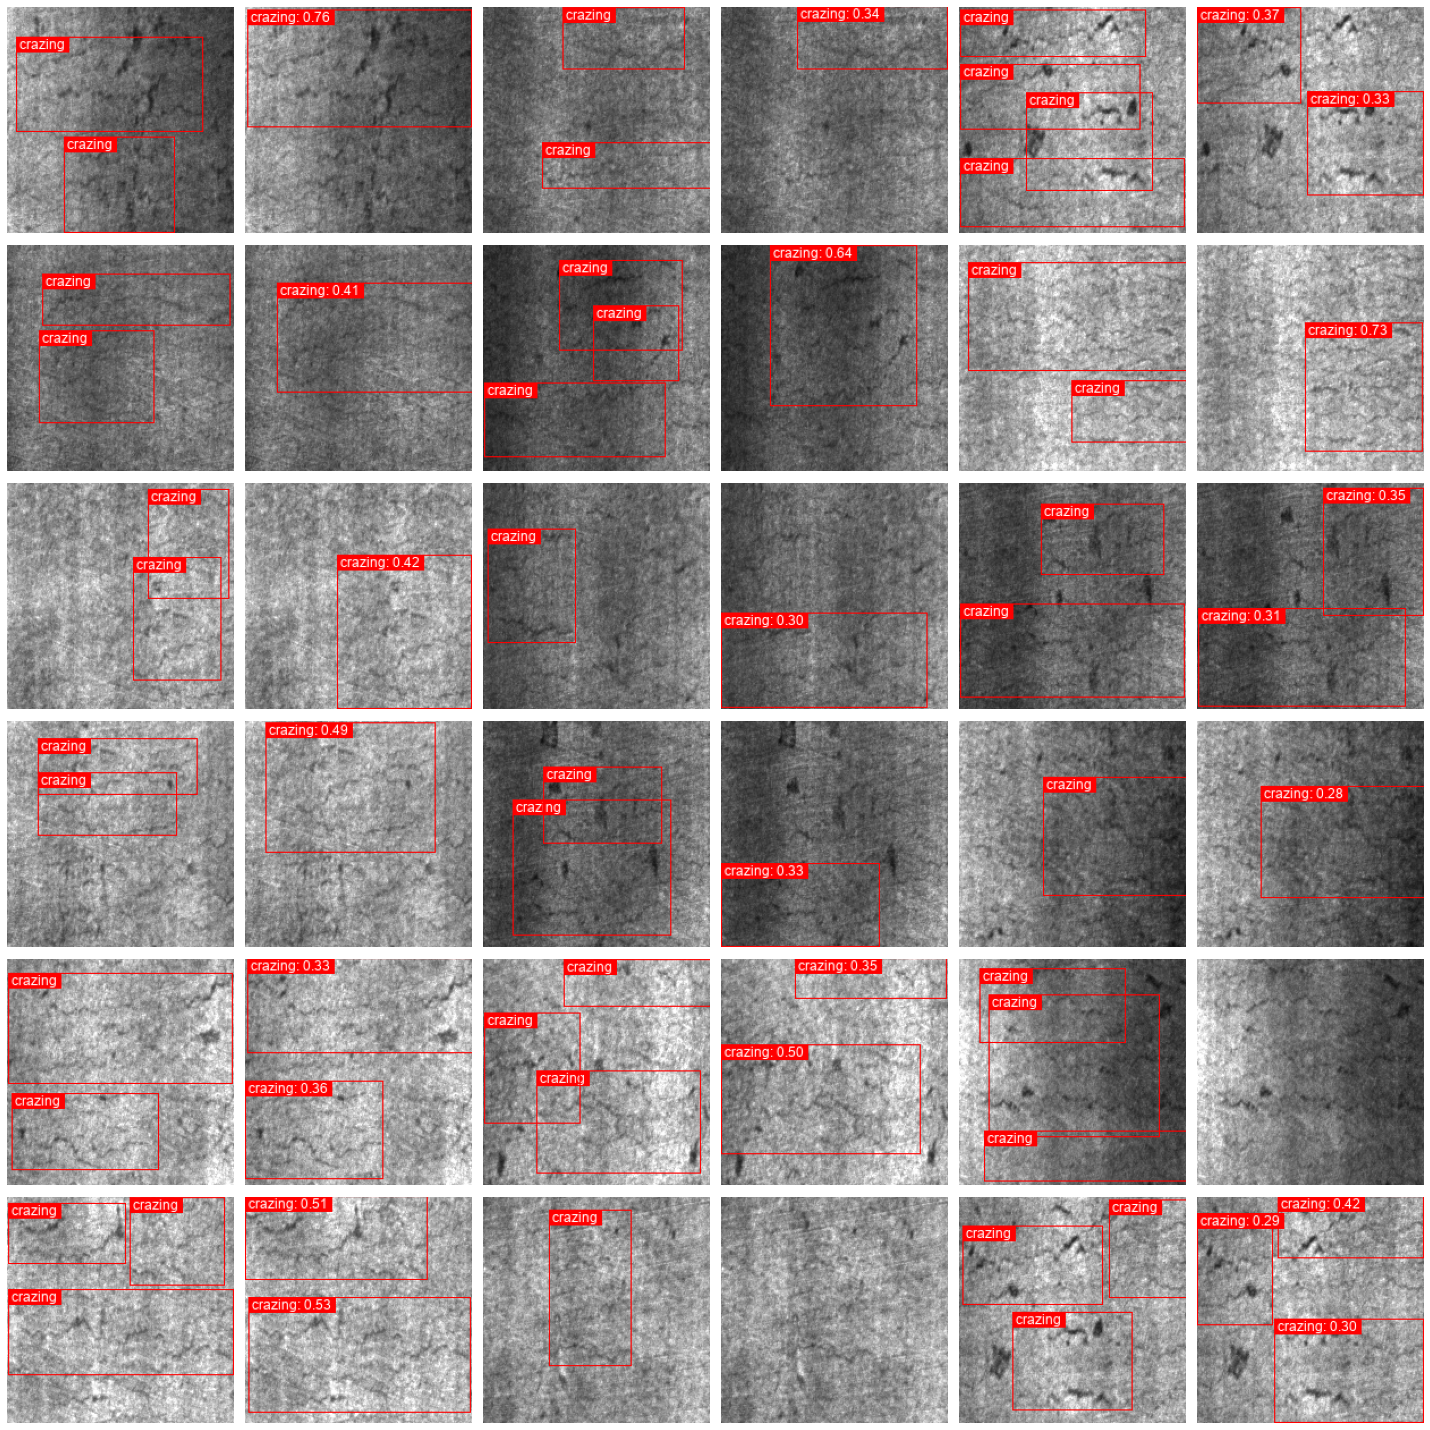

In [27]:
plt.figure(figsize=(20, 20))

for i in range(18):
    annotation_file = crazing_annotations[i]
    with open(annotation_file, 'r') as f:
        annotations = f.read().split('\n')[:-1]
        annotations = [_.split() for _ in annotations]
        annotations = np.array([[float(__) for __ in _] for _ in annotations])

    # image = Image.open(str(annotation_file).replace('labels', 'images').replace('txt', 'jpg'))
    image = crazing_images[i]

    plt.subplot(6, 6, 2*i + 1)
    plot_bbox(image, annotations[:, [1, 2, 3, 4, 0]])
    plt.axis('off')
    plt.subplot(6, 6, 2*i + 2)
    plot_bbox(image, results.xywhn[i].cpu())
    plt.axis('off')
    plt.tight_layout()

## Faster RCNN

The pre-trained models for detection, instance segmentation and keypoint detection are initialized with the classification models in torchvision.

The models expect a list of Tensor[C, H, W], in the range 0-1. The models internally resize the images but the behaviour varies depending on the model.

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [16]:
from torchvision.transforms import functional as F

In [17]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2
cd ..

cp vision/references/detection/utils.py ./
cp vision/references/detection/transforms.py ./
cp vision/references/detection/coco_eval.py ./
cp vision/references/detection/engine.py ./
cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 109147, done.
remote: Counting objects: 100% (1378/1378), done.
remote: Compressing objects: 100% (545/545), done.
remote: Total 109147 (delta 1229), reused 904 (delta 827), pack-reused 107769
Receiving objects: 100% (109147/109147), 211.07 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (94261/94261), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [18]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [19]:
def convert_to_fasterrcnn(info):
    boxes = []
    labels = []
    area = []
    iscrowd = []
    for bbox in info['bboxes']:
        boxes.append([bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']])
        # +1 for background as 0
        labels.append(class_name_to_id_mapping[bbox['class']] + 1)
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    # all objectes are not crowd
    iscrowd = torch.zeros((len(info['bboxes']),), dtype=torch.int64)
    return {
        'boxes': boxes,
        'labels': labels,
        'area': area,
        'iscrowd': iscrowd
    }

In [20]:
class DefectDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transforms=None):
        self.annotation_dir = dataset_dir
        self.transforms = transforms
        
        # load all files, sorting them to
        # ensure that they are aligned
        self.annotations = sorted(list(Path(os.path.join(dataset_dir, 'ANNOTATIONS')).glob('*.xml')))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation_file = self.annotations[idx]
        image_file = str(annotation_file).replace('ANNOTATIONS', 'IMAGES').replace('.xml', '.jpg')
        assert Path(image_file).is_file(), image_file + ' not exists'

        img = Image.open(image_file).convert('RGB')
        img = F.to_tensor(img)  # also, scale to [0, 1]

        info = extract_info_from_xml(annotation_file)

        target = convert_to_fasterrcnn(info)
        target['image_id'] = torch.tensor([idx])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

def get_transform(train):
    transforms = []

    # # convert PIL image to pytorch tensor
    # class ToTensor(object):
    #     def __call__(self, image, target):
    #         image = F.to_tensor(image)
    #         return image, target

    # transforms.append(ToTensor())
    if train:
        pass
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fasterrcnn_model(num_classes):
    # load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the pre-trained head with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [44]:
dataset = DefectDataset('surface_defect_detection/NEU-DET', get_transform(train=True))
dataset_test = DefectDataset('surface_defect_detection/NEU-DET', get_transform(train=False))

# split to train - test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:1260])
dataset_test = torch.utils.data.Subset(dataset_test, indices[1260:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn
)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# +1 for background (needed for faster rcnn)
num_classes = 7
fasterrcnn_model = get_fasterrcnn_model(num_classes)
fasterrcnn_model.to(device)

params = [p for p in fasterrcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [64]:
def average_precision(target_boxes, target_labels, output_boxes, output_labels, output_scores, iou_thres, num_classes):
    # torchvision.ops.box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor)
    """
    target_boxes - Python list of tensors shape (_, 4). Each tensor is ground truth bboxes coord for one image.
    target_labels - Python list of tensors shape (_). Each tensor is ground truth labels for one image.
    output_boxes - similar to target_boxes, but this is prediction.
    output_labels - similar to target_labels, but this is prediction.
    output_scores - objectness scores for predicted bbox
    iou_thres - IoU threshold to assign TP, FP, FN
    num_classes - number of classes in the dataset, INCLUDING background class
    """

    targets = []
    for image_id, (boxes, labels) in enumerate(zip(target_boxes, target_labels)):
        for box, label in zip(boxes, labels):
            targets.append(
                torch.cat([torch.unsqueeze(torch.tensor(image_id), 0),
                           torch.unsqueeze(label, 0), 
                           box]))
    target = torch.stack(targets)

    outputs = []
    for image_id, (boxes, labels, scores) in enumerate(zip(output_boxes, output_labels, output_scores)):
        for box, label, score in zip(boxes, labels, scores):
            outputs.append(
                torch.cat([torch.unsqueeze(torch.tensor(image_id), 0),
                           torch.unsqueeze(label, 0), 
                           torch.unsqueeze(score, 0), 
                           box]))
    outputs = torch.stack(outputs)

    # # for each class in dataset
    # for cls in range(num_classes):
    #     # gather ground truth bbox
    #     target_boxes

    return targets, outputs

In [42]:
class Evaluator:
    def __init__(self):
        self.target_boxes = []
        self.target_labels = []
        self.output_boxes = []
        self.output_labels = []
        self.output_scores = []

    def update(self, targets, outputs):
        for target in targets:
            self.target_boxes.append(target['boxes'])
            self.target_labels.append(target['labels'])
        for output in outputs:
            self.output_boxes.append(output['boxes'])
            self.output_labels.append(output['labels'])
            self.output_scores.append(output['scores'])
    
    def summary(self):
        
        for iou_thres in np.arange(0.5, 1, 0.95):
            pass
        return average_precision(self.target_boxes, self.target_labels, self.output_boxes, self.output_labels, self.output_scores, 0.5, 7)
        # {
        #     'AP@0.5:0.95': {}, #
        #     'mAP@0.5': {}, #
        #     'mAP@0.5:0.95': {}, #
        # }

In [ ]:
[[0, tensor(1), tensor([ 12.,  71., 136., 194.])], 
 [0, tensor(1), tensor([  3.,  19., 200.,  88.])], 
 [1, tensor(5), tensor([ 45.,  13., 200.,  46.])], 
 [1, tensor(5), tensor([ 23.,  85., 181., 190.])], 
 [1, tensor(5), tensor([  1., 118.,  76., 160.])], [2, tensor(3), tensor([ 62.,   4., 136.,  72.])], [2, tensor(3), tensor([ 72.,  96., 125., 167.])], [2, tensor(3), tensor([130.,  76., 195., 200.])], [2, tensor(3), tensor([107.,  35., 179.,  75.])], [3, tensor(2), tensor([ 71.,   1., 108.,  72.])], [3, tensor(2), tensor([ 88., 117., 125., 199.])], [4, tensor(2), tensor([ 85.,  81., 137., 180.])], [5, tensor(2), tensor([142., 130., 159., 170.])], [5, tensor(2), tensor([56., 34., 70., 56.])], [6, tensor(5), tensor([37.,  4., 89., 63.])], [6, tensor(5), tensor([ 22., 150.,  83., 200.])], [7, tensor(4), tensor([  2.,   5., 195., 195.])]]


In [58]:
torch.stack([torch.cat([torch.unsqueeze(torch.tensor(0), 0), torch.unsqueeze(torch.tensor(1), 0), torch.tensor([ 12.,  71., 136., 194.])]),
 torch.cat([torch.unsqueeze(torch.tensor(0), 0), torch.unsqueeze(torch.tensor(1), 0), torch.tensor([ 12.,  71., 136., 194.])])])

tensor([[  0.,   1.,  12.,  71., 136., 194.],
        [  0.,   1.,  12.,  71., 136., 194.]])

In [65]:
evaluate(fasterrcnn_model, data_loader, device, 10)

([tensor([  0.,   4.,  14.,   9., 188., 198.]), tensor([  0.,   3., 174.,   1., 200.,  48.]), tensor([  1.,   6.,  24.,  40.,  34., 199.]), tensor([  1.,   6., 108.,   1., 122., 199.]), tensor([  1.,   6., 129.,   1., 154., 199.]), tensor([  2.,   4.,   1.,   1., 179., 195.]), tensor([  2.,   3., 170.,   1., 198.,  66.]), tensor([  3.,   2.,  32.,  77.,  65., 181.]), tensor([ 3.,  2., 49., 32., 70., 73.]), tensor([  3.,   2., 116.,   6., 162., 199.]), tensor([  4.,   1.,  22.,  29., 188., 135.]), tensor([  4.,   1.,  57., 138., 186., 197.]), tensor([  4.,   1.,   1.,  89.,  62., 151.]), tensor([  5.,   3.,  18.,  17., 170., 134.]), tensor([ 5.,  3.,  1.,  1., 50., 30.]), tensor([  5.,   3.,  95., 124., 155., 185.]), tensor([  5.,   2.,  63., 140., 131., 197.]), tensor([  6.,   1.,   1.,  76.,  94., 123.]), tensor([  6.,   1.,  98.,  58., 169., 134.]), tensor([  7.,   5.,  57.,  22., 122., 134.]), tensor([  7.,   5.,  44., 110., 184., 198.])], tensor([[0.0000e+00, 4.0000e+00, 9.9161e-01

In [37]:
import time

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    epoch_loss = 0
    # data_loader = tqdm.tqdm(data_loader)

    start_time = time.time()

    for i, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  # returns losses and detections
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses

        # TODO: track training loss

        if i % print_freq == 0:    
            print(f"Epoch: [{epoch}]  [{i}/{len(data_loader)}]  Elapsed time: {time.time() - start_time}  lr: {optimizer.param_groups[0]['lr']}  loss: {losses}  loss_classifier: {loss_dict['loss_classifier'].item()}  loss_box_reg: {loss_dict['loss_box_reg'].item()}  loss_objectness: {loss_dict['loss_objectness'].item()}  loss_rpn_box_reg: {loss_dict['loss_rpn_box_reg'].item()}")

def evaluate(model, data_loader, device, epoch):
    
    evaluator = Evaluator()
    
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]

            outputs = model(images)
            outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

            # TODO evaluator using (targets, outputs) and print
            evaluator.update(targets, outputs)
            print(evaluator.summary())
            break


In [28]:
next(iter(data_loader))[1]

({'area': tensor([ 3960., 14112.]), 'boxes': tensor([[ 88.,   1., 108., 199.],
          [126.,   1., 198., 197.]]), 'image_id': tensor([1533]), 'iscrowd': tensor([0, 0]), 'labels': tensor([6, 2])},
 {'area': tensor([4266., 5994.]), 'boxes': tensor([[ 71.,   1., 150.,  55.],
          [ 84.,  71., 158., 152.]]), 'image_id': tensor([1341]), 'iscrowd': tensor([0, 0]), 'labels': tensor([5, 5])},
 {'area': tensor([2379., 5572.,  442.]),
  'boxes': tensor([[ 45.,   1.,  58., 184.],
          [ 64.,   1.,  92., 200.],
          [172., 116., 185., 150.]]),
  'image_id': tensor([1521]),
  'iscrowd': tensor([0, 0, 0]),
  'labels': tensor([6, 6, 2])},
 {'area': tensor([5754.]),
  'boxes': tensor([[157.,  62., 199., 199.]]),
  'image_id': tensor([1734]),
  'iscrowd': tensor([0]),
  'labels': tensor([6])},
 {'area': tensor([1632., 6304.]), 'boxes': tensor([[ 55., 122.,  79., 190.],
          [161.,   1., 193., 198.]]), 'image_id': tensor([463]), 'iscrowd': tensor([0, 0]), 'labels': tensor([2, 2])}

In [ ]:
num_epochs = 1

for epoch in range(1):
    train_one_epoch(fasterrcnn_model, optimizer, data_loader, device, epoch, print_freq=2)

In [24]:
num_epochs = 4

for epoch in range(num_epochs):
    train_one_epoch(fasterrcnn_model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(fasterrcnn_model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/158]  eta: 0:10:14  lr: 0.000037  loss: 3.0802 (3.0802)  loss_classifier: 2.1061 (2.1061)  loss_box_reg: 0.2136 (0.2136)  loss_objectness: 0.6313 (0.6313)  loss_rpn_box_reg: 0.1291 (0.1291)  time: 3.8908  data: 0.1975  max mem: 7158
Epoch: [0]  [ 10/158]  eta: 0:08:14  lr: 0.000355  loss: 1.9235 (1.8976)  loss_classifier: 1.5504 (1.4103)  loss_box_reg: 0.2054 (0.1988)  loss_objectness: 0.1970 (0.2369)  loss_rpn_box_reg: 0.0416 (0.0517)  time: 3.3402  data: 0.0469  max mem: 7423
Epoch: [0]  [ 20/158]  eta: 0:07:41  lr: 0.000673  loss: 0.8166 (1.2863)  loss_classifier: 0.4207 (0.8786)  loss_box_reg: 0.2054 (0.2107)  loss_objectness: 0.0701 (0.1498)  loss_rpn_box_reg: 0.0412 (0.0472)  time: 3.3170  data: 0.0319  max mem: 7423
Epoch: [0]  [ 30/158]  eta: 0:07:08  lr: 0.000991  loss: 0.5902 (1.0559)  loss_classifier: 0.2835 (0.6826)  loss_box_reg: 0.2134 (0.2110)  loss_objectness: 0.0589 (0.1194)  loss_rpn_box_reg: 0.0342 (0.0430)  time: 3.3570  data: 0.0315  max mem: 7423


In [ ]:
# torch.save(fasterrcnn_model.state_dict(),'fasterrcnn.pt')

# !tar -czf fasterrcnn.tar.gz fasterrcnn.pt
# !tar -czf - fasterrcnn.pt | split --bytes=80MB - fasterrcnn.tar.gz

In [32]:
!mkdir saved_model
!cat surface_defect_detection/saved_model/fasterrcnn.tar.gza* > surface_defect_detection/saved_model/fasterrcnn.tar.gz
!tar -xf surface_defect_detection/saved_model/fasterrcnn.tar.gz -C saved_model/

In [33]:
fasterrcnn_model.load_state_dict(torch.load('saved_model/fasterrcnn.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

FPS: 0.16268545437577803


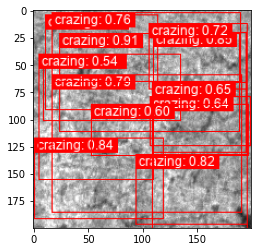

In [34]:
import time
i = 6

imgs, labels = next(iter(data_loader_test))
imgs = [img.to(device) for img in imgs]
fasterrcnn_model.eval()
with torch.no_grad():
    model_time = time.time()
    preds = fasterrcnn_model(imgs)
    model_time = time.time() - model_time
    print('FPS:', 8/model_time)
    preds = [{k: v.cpu() for k, v in t.items()} for t in preds]

img = imgs[i].permute(1, 2, 0).mul(255).byte().cpu().numpy()
pred = preds[i]

annotations = []
for (xmin, ymin, xmax, ymax), score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
    if score > 0.5:     # change this to see effect
        annotations.append([
                            (xmin + xmax) / 2 / img.shape[0],
                            (ymin + ymax) / 2 / img.shape[1],
                            (xmax - xmin) / img.shape[0],
                            (ymax - ymin) / img.shape[1],
                            score,
                            label - 1
        ])
plot_bbox(img, np.array(annotations))

In [26]:
len(preds)

8

//TODO viet lai ham theo format: DRAW_BOUNDING_BOXES

https://remo.ai/docs/tutorial_pytorch_object_detection/

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

https://pytorch.org/vision/stable/ops.html

https://giou.stanford.edu/

//TODO:

đưa tất cả (true & pred) bboxes của 1 ảnh crazing về một cái bbox duy nhất, rồi tính lại AP của class crazing xem có tốt hơn không? => viết hàm tính mAP, confusion matrix

faster rcnn: các kiểu augmentation (mixcut, mosaic) nào có ảnh hưởng?, format đầu vào

https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

https://blog.roboflow.com/yolov4-data-augmentation/